# 線形回帰（教師有り学習）

ここから始まるレクチャーでは、線形回帰について学びます。
scikit-learnを使って、線形回帰のモデルを作り、新しいデータを使った予測を試みます。
サンプルデータは、アメリカ大都市の住宅価格です。初めは、1つだけの変数を使った単回帰をやってみます。

線形回帰の数学的な背景に興味がある場合は、以下のサイトが参考になります。
- [wikipedia（日本語）](https://ja.wikipedia.org/wiki/%E7%B7%9A%E5%BD%A2%E5%9B%9E%E5%B8%B0)
- [wikipedia（英語）](http://en.wikipedia.org/wiki/Linear_regression) 
- Andrew Ngの動画（英語）もあります [youtube](https://www.youtube.com/watch?v=5u4G23_OohI).

4回に分かれているレクチャーの概要です。

    Step 1: データの準備
    Step 2: ひとまず可視化
    Step 3: 最小二乗法の数学的な背景
    Step 4: NumPyを使った単回帰
    Step 5: 誤差について
    Step 6: scikit-learnを使った重回帰分析
    Step 7: 学習（Training）と検証（Validation）
    Step 8: 価格の予測
    Step 9: 残差プロット

### Step 1: データの準備

scikit-learnに用意されているサンプルデータを使います。

In [69]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [71]:
from sklearn.datasets import fetch_california_housing

# 住宅価格サンプルデータのロード
housing = fetch_california_housing()

In [72]:
# Descriptionは説明です。
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

### Step 2: ひとまず可視化

Text(0, 0.5, 'Number of houses')

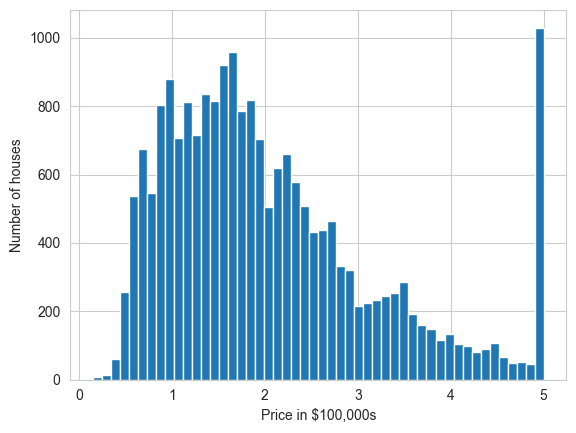

In [73]:
# 価格のヒストグラムです。 (これがモデルを作って、最終的に予測したい値です。）

plt.hist(housing.target, bins=50)

plt.xlabel('Price in $100,000s')
plt.ylabel('Number of houses')

In [74]:
# DataFrameを作ります。
housing_df = DataFrame(housing.data)

# 列名をつけます。
housing_df.columns = housing.feature_names

housing_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [75]:
housing_df.shape

(20640, 8)

In [76]:
# DataFrameに新しい列を作って、目的変数（価格）を格納しておきます。

housing_df['Price'] = housing.target

今度は散布図を描いてみます。年収と価格の関係を見てみましょう。

Text(0.5, 0, 'Median Income')

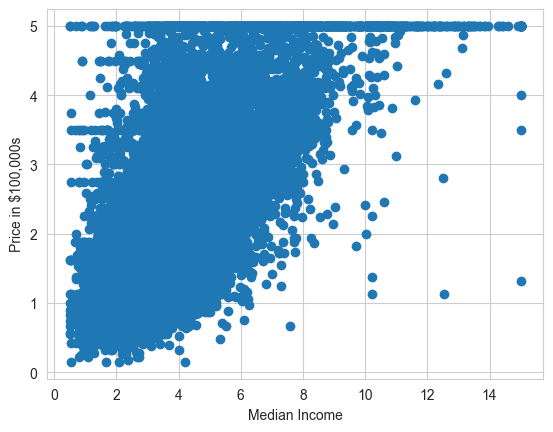

In [78]:
plt.scatter(housing_df['MedInc'], housing_df['Price'])

plt.ylabel('Price in $100,000s')
plt.xlabel('Median Income')

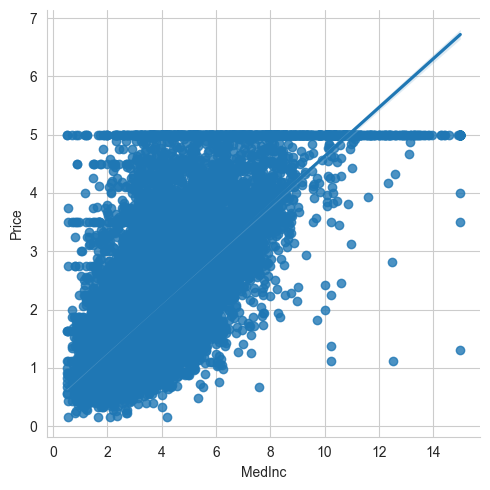

In [79]:
# lmplotを使って、回帰直線を引きます。

sns.lmplot(housing_df, x='MedInc', y='Price')

ここまでLec72

### Step 3: 最小二乗法の数学的な背景

回帰直線の係数を求めるのに使われる、「最小二乗法」について、すこし数学的になりますが、その背景を説明します。

回帰直線は、データ全体にうまく適合するように、描かれています。各点から、回帰直線への距離をDとしてみましょう。このDを最小にすれば良いわけです。このイメージを図にしてみます。

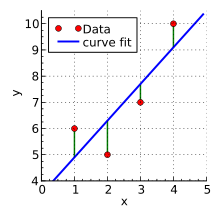

In [80]:
# wikipediaから拝借します。
from IPython.display import Image
url = 'http://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Linear_least_squares_example2.svg/220px-Linear_least_squares_example2.svg.png'
Image(url)

各点（赤）の座標は、(x, y)です。ここから、回帰直線（青線）への距離をDとすると、以下の値を最小にする直線が一番よさそうです。

$$ d = D_{1}^2 + D_{2}^2 + D_{3}^2 + D_{4}^2 + ....+ D_{N}^2$$

直線の式は、

$$y=ax+b$$

で表現されます。いま、$a$と$b$を求めたいのですが、これはdを最小にする$a$と$b$を見つけ出すという問題と同じです。

この問題はもちろん、手で計算することで解くことができますが、ここではこの計算をNumpyやscikit-leranにお任せします。
もし数学的な計算方法に興味がある方は、[こちら](http://mathtrain.jp/seikiequ)が大変参考になります。

### Step 4: Numpyを使った単回帰

Numpyは線形代数のライブラリの一部に、最小二乗法を解く関数を持っています。
まずはこれを使って、単回帰(説明変数が1つ）をやってみます。その後、scikit-learnを使って、重回帰（説明変数が複数）に進んで行きましょう。

入力として、2つのarray（XとY）を用意します。

Yは目的変数なので1次元のarrayですが、Xは2次元のarrayで、行がサンプル、列が説明変数です。単回帰の場合は、列が1つになりますですので、そのshapeは、(20640,1)です。これを作るには、いくつか方法がありますが、ここでは、vstackを使ってみます。

In [81]:
# 年収
X = housing_df['MedInc']
print(X.shape)
X

(20640,)


0        8.3252
1        8.3014
2        7.2574
3        5.6431
4        3.8462
          ...  
20635    1.5603
20636    2.5568
20637    1.7000
20638    1.8672
20639    2.3886
Name: MedInc, Length: 20640, dtype: float64

In [82]:
# これを2次元のarrayにします。
X = np.vstack(X)
print(X.shape)
X

(20640, 1)


array([[8.3252],
       [8.3014],
       [7.2574],
       ...,
       [1.7   ],
       [1.8672],
       [2.3886]])

In [83]:
Y = housing_df['Price']
Y

0        4.526
1        3.585
2        3.521
3        3.413
4        3.422
         ...  
20635    0.781
20636    0.771
20637    0.923
20638    0.847
20639    0.894
Name: Price, Length: 20640, dtype: float64

numpyで単回帰をするには、ここから、少しだけ工夫が必要です。

直線の式は、
$$y=ax+b$$
これは、次のように書き直すことができます。
$$y=Ap$$
ただし:
$$A = \begin{bmatrix}x & 1\end{bmatrix}$$

$$p= \begin{bmatrix}a \\b\end{bmatrix}$$

Aとpはベクトルで、これらの内積で直線の式を表現しただけです。
データをこの形式に変更する必要があるので、次のようなコードを実行します。

In [84]:
# Xを[X 1]の形にします。
X = np.array([[value[0], 1] for value in X])
X

array([[8.3252, 1.    ],
       [8.3014, 1.    ],
       [7.2574, 1.    ],
       ...,
       [1.7   , 1.    ],
       [1.8672, 1.    ],
       [2.3886, 1.    ]])

In [85]:
# 最小二乗法の計算を実行します。

a, b = np.linalg.lstsq(X, Y)[0]

/var/folders/k5/g89wjxz9235346v2wbtwbqdm0000gn/T/ipykernel_50116/1563434560.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a, b = np.linalg.lstsq(X, Y)[0]


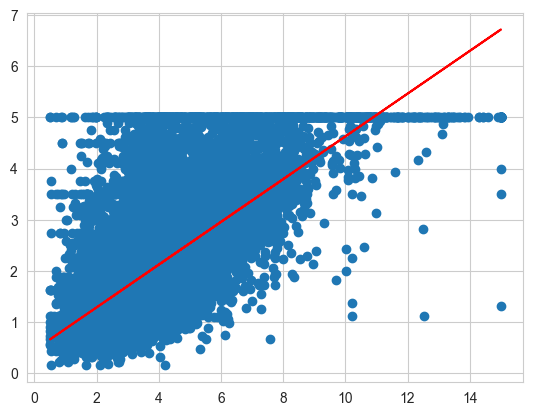

In [86]:
# まずは元のデータをプロットします。
plt.plot(housing_df['MedInc'], housing_df['Price'], 'o')

# 求めた回帰直線を描きます。
x = housing_df['MedInc']
plt.plot(x, a*x + b, 'r')

ここまでLec73

### Step 5: 誤差について

すべてのデータが完全に乗る直線を描くことは出来ませんので、どうしても誤差が出ます。

最小化しているのは誤差の2乗和でした。全体の誤差が分かれば、それをサンプルの数で割って平方根をとることで、ちょうど標準偏差のようなイメージで、平均誤差を計算できます。

[numpy.linalg.lstsqのドキュメント（英語）](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html)

In [87]:
# 結果をすべて取得します。

result = np.linalg.lstsq(X, Y)

/var/folders/k5/g89wjxz9235346v2wbtwbqdm0000gn/T/ipykernel_50116/1641407615.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  result = np.linalg.lstsq(X, Y)


In [88]:
# 2つ目の要素に、誤差の合計が入っています。
error_total = result[1]

# 誤差の平均値の平方根を計算します。
rmse = np.sqrt(error_total/len(X))

print(f'平均二乗誤差の平方根は、{rmse[0]:0.2f}')

平均二乗誤差の平方根は、0.84


平均二乗誤差は、標準偏差に対応するので、95%の確率でこの値の2倍以上誤差が広がることは無いと結論付けあれます。
正規分布の性質を思い出したい方は、[こちらを参照](http://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule).

### Step 6:  scikit-learnを使った重回帰分析

説明変数が1つだけだと単回帰ですが、重回帰は複数の説明変数を同時に扱うことができます。

scikit-learnの線形回帰ライブラリを利用します。
[linear regression library](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

sklearn.linear_model.LinearRegressionクラスは、データを元にモデルを作り、予測値を返すことができます。

モデルを作る時には、fit()メソッドを呼び、予測をするときは、predict()メソッドを使います。

今回は重回帰モデルを使いますが、他のモデルも同じように、fitとpredictメソッドを実装しているところが、scikit-learnの便利なところです。

In [89]:
import sklearn
from sklearn.linear_model import LinearRegression

In [90]:
# まず、LinearRegressionクラスのインスタンスを作ります。
lreg = LinearRegression()

lreg.fit() はデータを元にモデルを作ります。

lreg.predict() は作られたモデルを元に、予測値を返します。

lreg.score()は、決定係数を返します。
決定係数は、説明変数でどれくらいうまく目的変数の値を説明出来ているかの指標になります。[Wikipediaへのリンク](https://ja.wikipedia.org/wiki/%E6%B1%BA%E5%AE%9A%E4%BF%82%E6%95%B0)

カリフォルニアの住宅価格を、目的変数と説明変数に分けます。

In [91]:
# 説明変数
X_multi = housing_df.drop('Price', axis=1)

# 目的変数
Y_target = housing_df['Price']

In [92]:
# モデルを作ります。
lreg.fit(X_multi, Y_target)

LinearRegression()

In [93]:
print(f'切片の値は{lreg.intercept_:0.2f}')

切片の値は-36.94


In [94]:
print(f'係数の数は{len(lreg.coef_)}個')

係数の数は8個


単回帰の時は、直線だったので係数aと切片bはともに1つでした。今は、切片は1つですが、係数が8個あります。これは8個変数がある式になっている事を意味しています。

$$ y = b + a_1 x_1 + a_2 x_2 + \dots + a_{8} x_{8} $$

実際に求められた係数を見ていきましょう。

In [95]:
# 新しいDataFrameを作ります。
coeff_df = DataFrame(housing.feature_names,
                     columns = ['Features'])

#求められた係数を代入します。
coeff_df["Coefficient Estimate"] = lreg.coef_

coeff_df

,Features,Coefficient Estimate
0,MedInc,0.436693
1,HouseAge,0.009436
2,AveRooms,-0.107322
3,AveBedrms,0.645066
4,Population,-0.000004
5,AveOccup,-0.003787
6,Latitude,-0.421314
7,Longitude,-0.434514


ここまでLec74

### Step 7: 学習（Training）と検証（Validation）

ここまではすべてのデータを使って来ましたが、機械学習では一部のデータを使ってモデルを作り、残りのデータを使ってモデルを検証するという作業をします。

サンプルをどのように分けるかが問題ですが、scikit-learnに便利な関数train_test_splitを使ってみましょう。

サンプルを学習用のtrainと検証用のtestに分けてくれます。追加のパラメータを渡せば、割合も調整できます。
[詳しくはこちら](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [96]:
# 説明変数をX、目的変数をYとして受け取ります。

X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_multi, housing_df['Price'])

In [97]:
# どんな感じに分かれたか、確認してみます。
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(15480, 8) (5160, 8) (15480,) (5160,)


### Step 8: 価格の予測

In [98]:
# まずはインスタンスを作ります。
lreg = LinearRegression()

# fitでモデルを作りますが、使うのは学習用のデータだけです。
lreg.fit(X_train, Y_train)

LinearRegression()

予測を、学習用のデータとテスト用のデータ、両方でやってみましょう。

In [99]:
pred_train = lreg.predict(X_train)

pred_test = lreg.predict(X_test)

それぞれの平均二乗誤差を計算できます。

In [100]:
print('X_trainを使ったモデルの平均二乗誤差＝{:0.2f}'.format(np.mean((Y_train - pred_train) ** 2)))
    
print('X_testを使ったモデルの平均二乗誤差＝{:0.2f}'.format(np.mean((Y_test - pred_test) ** 2)))

X_trainを使ったモデルの平均二乗誤差＝0.52
X_testを使ったモデルの平均二乗誤差＝0.53


### Step 9 : 残差プロット

回帰分析では、実際に観測された値と、モデルが予測した値の差を、残差と呼びます。

$$ 残差 = 観測された値 - 予測された値 $$

横軸に予測値、縦軸に実際の値との差をプロットしたものを、残差プロットと呼びます。

残差プロットを描いて、多くのデータがy=0の直線に近いところに集まれば、よいモデルが出来たことがわかります。
また、均一に点がプロットされている場合、線形回帰が適切だったことが分かります。そうでは無い場合は、非線形なモデルを使うことを検討しましょう。（これは後のレクチャーで解説します。）

Text(0.5, 1.0, 'Residual Plots')

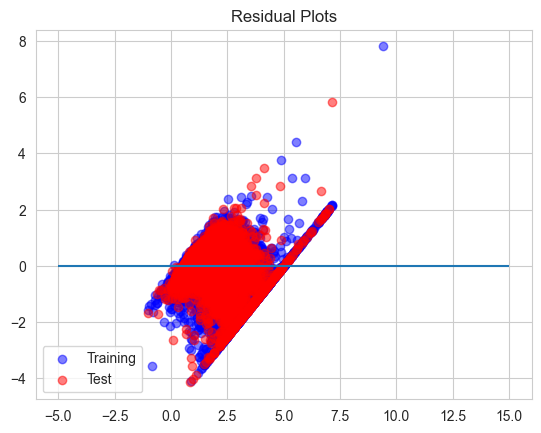

In [101]:
# 学習用のデータの残差プロットです。
train = plt.scatter(pred_train,
                    (pred_train-Y_train),
                    c='b', alpha=0.5)

# テスト用のデータの残差プロットです。
test = plt.scatter(pred_test,
                   (pred_test-Y_test),
                   c='r', alpha=0.5)

# y=0の水平な線を描いておきます。
plt.hlines(y=0, xmin=-5, xmax=15)

plt.legend((train, test), ('Training', 'Test'), loc='lower left')
plt.title('Residual Plots')

英語になってしまいますが、scikit-learnのドキュメントには有用な情報が沢山あります。是非チェックしてみてください。
http://scikit-learn.org/stable/modules/linear_model.html#linear-model